# 16 - Regression Discontinuity Design

새삼스럽지만 자연의 연속성은 인상적입니다. 큰 나무는 싹에서 자라고, 상처는 천천히 아물며, 순식간에 이동할 수 없습니다. 사회 또한 연속적입니다. 단 하루 만에 사업을 성공할 수 없습니다. 부자가 되기 위한 일관된 노력이 필요합니다. 또한, 선형 회귀의 작동 방법을 알기 위해서는 적어도 수년은 공부해야 합니다. 자연은 급격한 변화를 보이지 않습니다.

> 마음으로 도를 안아 그것에서 떠나지 않을 수 있는가?
\- 도덕경, 노자

**데이터의 뾰족 점은 부자연스러우며** 인위적일 가능성이 있습니다. 인위적인 사건은 보통 반사실을 동반합니다. 이상한 사건은 일반적인 상황에 대한 통찰을 줄 수 있습니다. `Regression Discontinuity Design`(회귀 불연속 설계)의 핵심은 인위적인 도약을 다루는 것에서 시작합니다.

![img](./data/img/rdd/smooth.png)

기본 아이디어는 다음과 같습니다. `treatment` $T$와 `potential outcome` $Y_0$, $Y_1$가 있다고 가정해봅시다. $T$는 `running variable` $R$의 불연속 함수입니다.

$
D_i = \mathcal{1}\{R_i>c\}
$

$R$이 임계값 $c$보다 작을 때는 `treatment`가 0, $c$보다 클 때는 1입니다. $R>c$이면 $Y_1$, $R<c$이면 $Y_0$를 측정할 수 있습니다. `potential outcome`은 정확히 측정할 수 없는 2개의 함수처럼 생각할 수 있습니다. $Y_0(R)$, $Y_1(R)$은 정의되어 있지만 측정할 수는 없습니다. 임계값 $c$는 두 값 중 하나를 보여주는 스위치 역할을 합니다.

![img](./data/img/rdd/rdd.png)

`Regression Discontinuity`의 아이디어는 임계값 전후의 `outcome`을 비교해 임계값에서 처치 효과를 구하는 것입니다. **sharp RD** 설계라 불리는 방법으로 임계값에서 처치 받을 확률이 0에서 1로 순간적으로 바뀌는 특성을 활용합니다. 덜 극적인 버전으로는 **fuzzy RD** 설계가 있습니다.

## Is Alcohol Killing You?

`Regression Discontinuity`의 예시로 최소 음주 연령 정책을 살펴보겠습니다. 브라질을 포함한 대부분 국가는 만 18세 이상부터 음주할 수 있지만, 미국 대부분 주에서는 만 21세부터 술을 마실 수 있습니다. 미국의 정책이 지나치게 보수적이므로 최소 음주 연령을 낮춰야 할까요? 아니면 다른 나라들이 최소 음주 연령을 높여야 할까요?

질문에 대한 답변 중 하나는 [Carpenter and Dobkin, 2009](https://www.aeaweb.org/articles?id=10.1257/app.1.1.164)입니다. 공공 정책의 목표에 따라 사망률을 최대한 낮춰야 한다고 주장할 수 있습니다. 음주가 사망률을 크게 높인다면 최소 음주 연령을 높여야 할 것입니다.

음주가 사망률에 미치는 영향을 추정하기 위해 법적 음주 연령이 자연에 불연속성을 부과한다는 사실을 활용해 봅시다. 미국에서는 만 21세 미만은 법적으로 음주가 금지되어 있지만 (마시더라도 몰래, 적게 마십니다.) 만 21세 이상은 제한이 없습니다. 따라서 음주 가능성은 만 21세를 기점으로 크게 높아지며 이는 `RDD`로 다룰 수 있습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")

먼저 나이별로 집계된 사망률 데이터를 얻어봅시다. 개별 `row`는 평균 연령으로 집계된 값으로 `all`(모든 원인), `mva`(차량 사고), `suicide`(자살)에 의한 평균 사망률을 포함합니다.

In [2]:
drinking = pd.read_csv("./data/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


보기 쉽게 (또한, 나중에 보게 될 중요한 이유로) `running variable`인 `agecell`에서 임계값인 21을 빼겠습니다. 이제 `agecell`=0을 중심으로 `treatment`(음주 제한) 적용 여부가 나뉩니다.

In [3]:
drinking["agecell"] -= 21

x축에 `runing variable`, y축에 `all`, `mva`, `suicide`를 그려보면 음주 연령에 따른 사망률에 대한 단서를 얻을 수 있습니다.

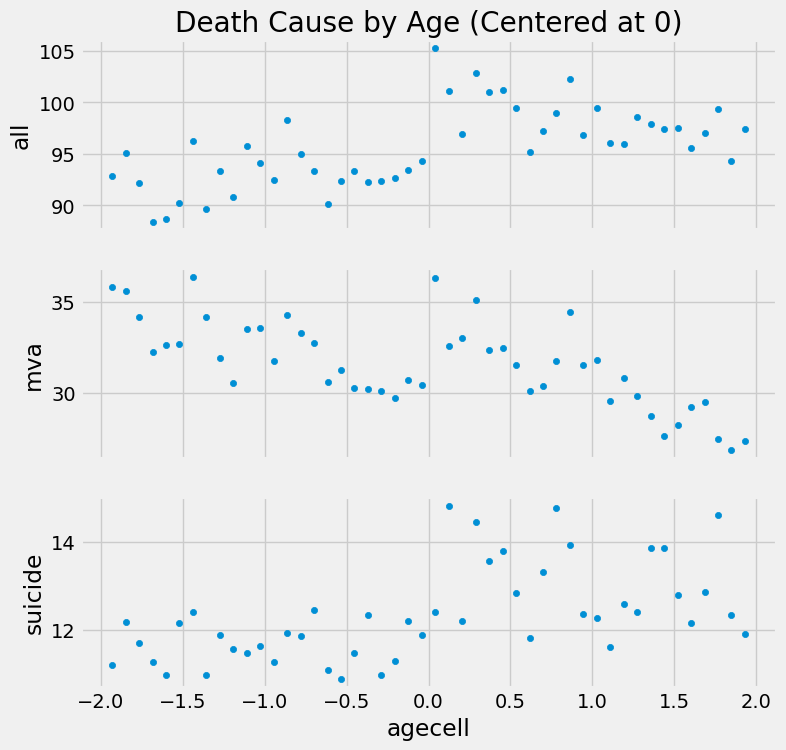

In [4]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);


특징이 보이는 것 같기도 하지만 더 구체적인 것이 필요해 보입니다. 임계값 근방에서 술이 사망률에 미치는 영향은 얼마나 큰가요? 추정값의 표준 오차는 얼마인가요?

## RDD Estimation

`RDD`는 임계값에서 `potential outcome`의 연속성에 기반을 둡니다. `running variable`이 오른쪽이나 왼쪽에서 임계값에 접근할 때 `potential outcome`의 한계는 같아야 합니다.

$$
\lim_{r \to c^-} E[Y_{ti}|R_i=r] = \lim_{r \to c^+} E[Y_{ti}|R_i=r]
$$

가정이 참이라면 임계값에서 인과 효과를 얻을 수 있습니다.

$$
\begin{align}
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=&\lim_{r \to c^+} E[Y_{1i}|R_i=r] - \lim_{r \to c^-} E[Y_{0i}|R_i=r] \\
=& E[Y_{1i}|R_i=r] - E[Y_{0i}|R_i=r] \\
=& E[Y_{1i} - Y_{0i}|R_i=r]
\end{align}
$$

위 수식은 일종의 `LATE`(국소 평균 처치 효과)로 볼 수 있습니다. 임계값 근방에서만 알 수 있는 정보이기 때문입니다. 따라서 `RDD`는 국소적인 무작위 실험으로 생각할 수 있습니다. 임계값 근방에 있는 사람은 어느 쪽으로든 갈 수 있으며 우연히 임계값 전후로 나뉩니다. 임계값에서 어떤 사람은 만 21세 이하, 만 21세 이상으로 나뉘는데, 이를 결정하는 것은 생일로 꽤 무작위적입니다. `RDD`는 `RCT`의 최적 표준은 아니지만, 그에 준하며 설득력 있는 인과 관계를 보여줄 수 있습니다.

임계값에서의 처치 효과는 위 공식에서 양쪽의 한계 값으로 알 수 있습니다. 간단하게는 선형 회귀를 사용합니다.

![img](./data/img/rdd/ols.png)

선형 회귀를 적합 시키기 위해 `running variable`과 임계값에 해당하는 더미를 상호작용(곱하기)시킵니다.

$
y_i = \beta_0 + \beta_1 r_i + \beta_2 \mathcal{1}\{r_i>c\} + \beta_3 \mathcal{1}\{r_i>c\} r_i
$

기본적으로는 임계값 전후로 선형 회귀를 적합 시키는것과 같습니다. $\beta_0$는 임계값 이하 데이터의 선형 회귀 절편, $\beta_0+\beta_2$는 임계값 이상 데이터의 선형 회귀 절편입니다.

이제 `running variable`을 임계값 중심에 맞추는 이유가 나옵니다. 전처리 후 임계값은 0이므로 $\beta_0$은 임계값 이하 선형 회귀의 한계 값입니다 ($\beta_0=\lim_{r \to c^-} E[Y_{ti}|R_i=r]$). 비슷하게 $\beta_0+\beta_2$는 임계값 이상 선형 회귀의 한계 값입니다. 따라서,

$
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=\beta_2=E[ATE|R=c]
$

입니다.

모든 사망률에 대한 음주 영향을 추정하는 코드는 아래와 같습니다.

In [5]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all~agecell*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


모델은 음주가 사망률을 7.6627포인트 증가시킴을 말해줍니다. 음주는 모든 원인에 의한 사망률을 약 8% 올립니다 $(100 \times ((7.6627+93.6184) / 93.6184 - 1) \sim 8)$. 모델은 인과 효과에 대한 표준 오차도 제공합니다. `p-value`가 0.01보다 작으므로 인과 효과는 통계적으로 유의합니다.

모델의 결과를 시각화해봅시다. 마치 두 개의 회귀선이 있는 것처럼 보입니다. 하나는 임계값 이하, 다른 임계값 이상 데이터에 대한 선형 회귀 모델입니다.

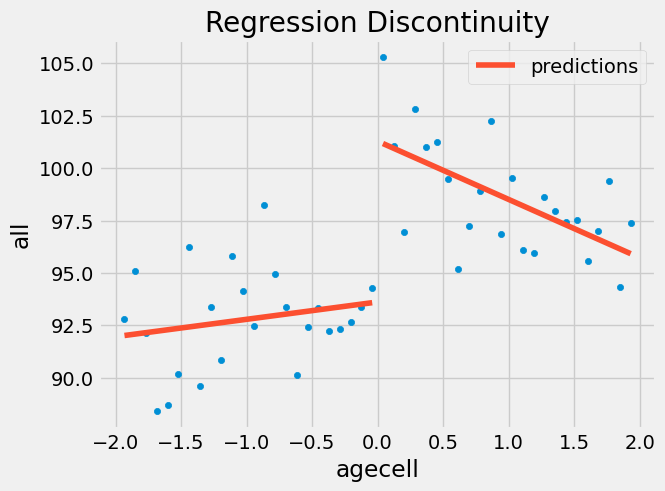

In [6]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity");

다른 사망률 원인에 대해서도 똑같이 할 수 있습니다.

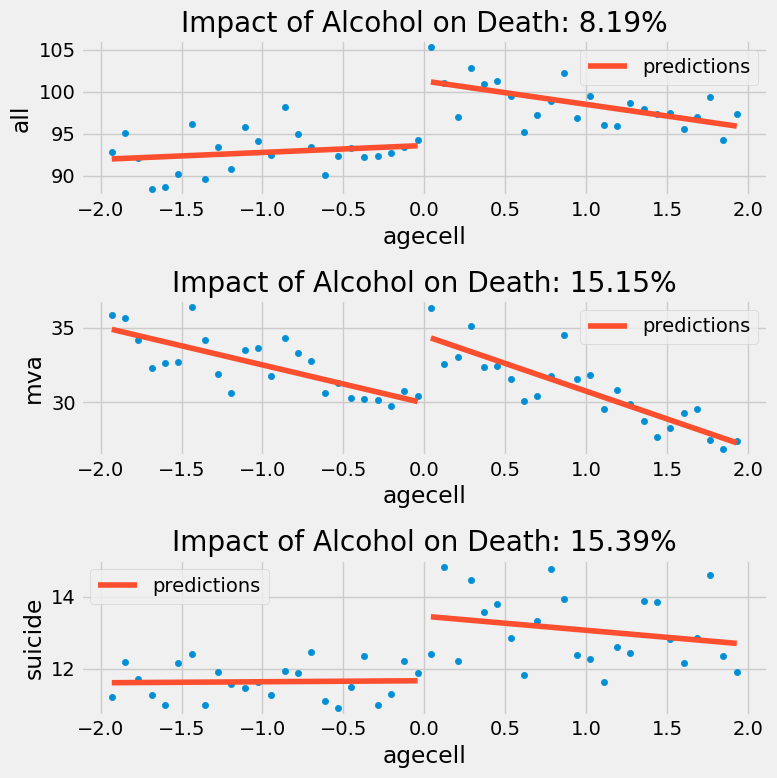

In [7]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

`RDD`는 음주가 자살과 교통사고로 사망할 확률을 15%까지 증가시킨다고 추정하는데 상당한 큰 값입니다. 사망률 감소를 위해 최소 음주 연령을 낮추면 안 된다는 주장을 뒷받침하는 설득력 있는 근거가 될 수 있습니다.

### Kernel Weighting

`Regression Discontinuity`는 선형 회귀의 `extrapolations`(외삽)에 크게 의존합니다. 회귀선 2개의 시작과 끝값으로 추정하고 있으므로 이러한 한계를 올바르게 인지해야 합니다. 때로는 선형 회귀가 임계값과 먼 데이터를 더 많이 적합 시키려 할 수 있습니다. 이때 추정값이 잘못 될 수 있습니다.

문제를 해결하는 한 가지 방법은 임계값 근방 데이터에 높은 가중치를 부여하는 것입니다. 가중치 할당 방법에는 여러 방법이 있지만, 일반적으로 **triangular kernel**(삼각 커널)을 사용합니다.

$
K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)
$

커널의 첫 번째 항은 임계값에 얼마나 가까운지 나타내는 함수입니다. 얼마나 가까울까요? `bandwidth`(대역폭)을 나타내는 $h$로 결정됩니다. 두 번째 항은 가중치 함수입니다. 임계값에서 멀수록 가중치는 작아집니다. 가중치가 작아지는 속도는 대역폭에 의해 결정됩니다. 대역폭이 크다면 가중치는 천천히 작아집니다. 대역폭이 작으면 빠르게 0으로 수렴합니다.

쉽게 이해하기 위해 앞의 예시에 커널을 적용해 봅시다. 대역폭은 1입니다. 따라서 만 20세부터 만 22세까지 데이터만 고려합니다.

In [8]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

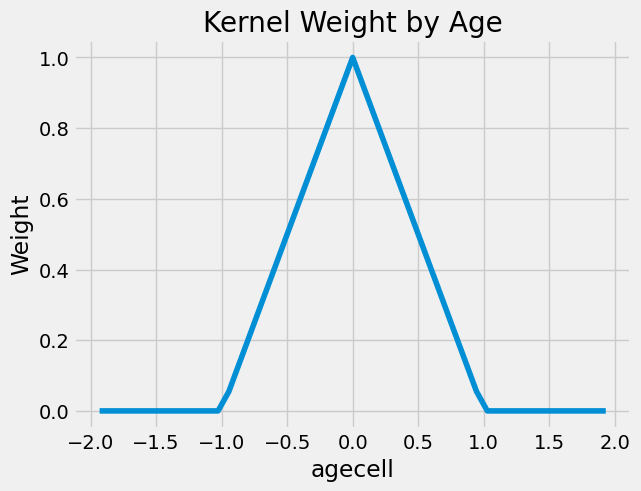

In [9]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

커널을 문제에 적용하면 모든 사망률 원인에 대한 음주의 영향은 더 커집니다. 7.6627에서 9.7004로 커졌습니다. 여기서는 `ols` 대신 `wls`를 사용합니다.

In [10]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


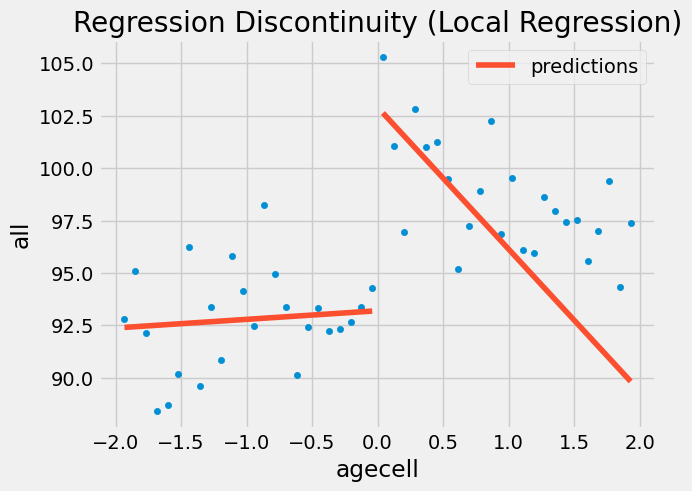

In [11]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

다른 사망률 원인에 대해서는 아래와 같습니다. 임계값 이상의 선형 회귀가 가장 오른쪽의 데이터를 고려하지 않으므로 음의 방향으로 기울기가 커집니다.

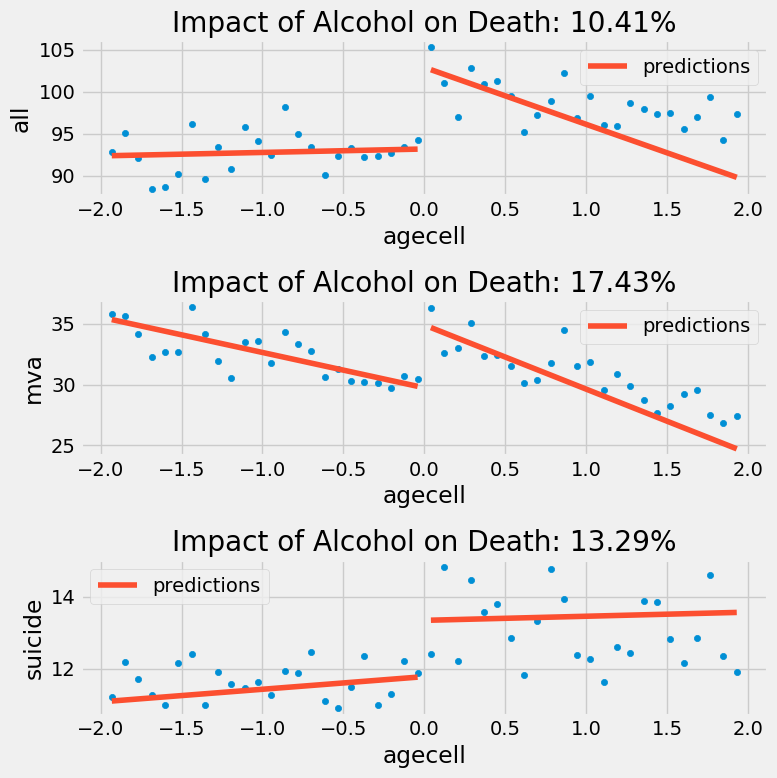

In [12]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

자살을 제외하고는 음주에 대한 부정적인 영향이 더 커진 것으로 보입니다. 음주가 사망률에 미치는 영향이 분명하므로 사망률을 최소화하기 위해 법적 음주 연령을 낮추면 안 됩니다.

음주 예시에서는 `RDD`가 완벽하게 작동하는 상황에 해당합니다. 다음 절에서는 `RDD`의 신뢰도를 확인하기 위해 해야 할 진단방법을 배우겠습니다. 예시로 교육이 소득에 미치는 영향을 다시 한번 추정해보겠습니다.

## Sheepskin Effect and Fuzzy RDD

경제학에는 교육이 소득에 미치는 영향에 대한 두 가지 주장이 있습니다. 첫 번째는 교육은 사람들의 생산성을 높여 소득을 올린다는 일반적인 주장입니다. 두 번째 주장은 교육은 단순한 신호 전달 메커니즘에 해당한다는 주장입니다. 교육은 사람들로 하여금 어려운 시험과 학문적인 과제들을 겪게 하며, 모든 과정을 성공적으로 완료한 사람은 능력 있는 사람임을 시장에 알립니다. 교육은 사람들을 더 생산적으로 만들기보다는 얼마나 생산적이었는지 시장에 알려주는 신호를 줄 뿐입니다. 따라서 가장 중요한 것은 졸업장입니다. 만약 졸업장을 받는다면 더 많은 돈을 벌 것입니다. 실제 능력과 상관없이 학위에 따라 좋은 대우를 받는 효과를 **양가죽 효과**라 부릅니다. 옛날에는 졸업장이 양가죽으로 되어 있었기 때문입니다. 

양가죽 효과를 검증하기 위해 [Clark and Martorell](https://faculty.smu.edu/millimet/classes/eco7321/papers/clark%20martorell%202014.pdf)에서는 12학년 졸업이 소득에 미치는 영향을 측정했습니다. 연구자들은 `running variable`를 만들기 위해 텍사스 교육 시스템을 활용했습니다.

텍사스에서는 졸업 시험을 통과해야 졸업장을 받을 수 있습니다. 시험은 10학년부터 치를 수 있는데 12학년 말까지 마쳐야 합니다. 연구진의 아이디어는 마지막 시험을 본 학생들의 데이터를 비교하는 것입니다. 시험을 겨우 통과한 학생과 아슬아슬하게 떨어진 학생의 수준은 비슷할 것입니다. 하지만 신호 전달 측면에서 전혀 다릅니다. 간신히 합격한 사람만 졸업장을 받기 때문입니다.

In [13]:
sheepskin = pd.read_csv("./data/sheepskin.csv")[["avgearnings", "minscore", "receivehsd", "n"]]
sheepskin.head()

,avgearnings,minscore,receivehsd,n
0,11845.086,-30.0,0.416667,12
1,9205.679,-29.0,0.387097,31
2,8407.745,-28.0,0.318182,44
3,11114.087,-27.0,0.377778,45
4,10814.624,-26.0,0.306667,75


데이터는 `running variable`별로 집계되었습니다. `running variable`인 `minscore`외에도 `outcome`인 `avgearnings`, 졸업장을 받을 확률인 `receivehsd`, 데이터의 크기인 `n`을 포함합니다. 예를 들어 12명의 학생 중에서 -30점 이하의 점수를 받은 학생은 5명에 불과합니다 $(12 \times 0.416 \sim 5)$.

데이터에서 `treatment` 할당은 확률적입니다. 합격선 아래에 있는 학생이라도 몇몇은 졸업장을 받습니다. 따라서 회귀 불연속성은 날카롭기보다 **fuzzy**합니다. 졸업장을 받을 확률은 0에서 1로 뛰어오르지 않습니다. 대신 0.5에서 0.9로 올라갑니다.

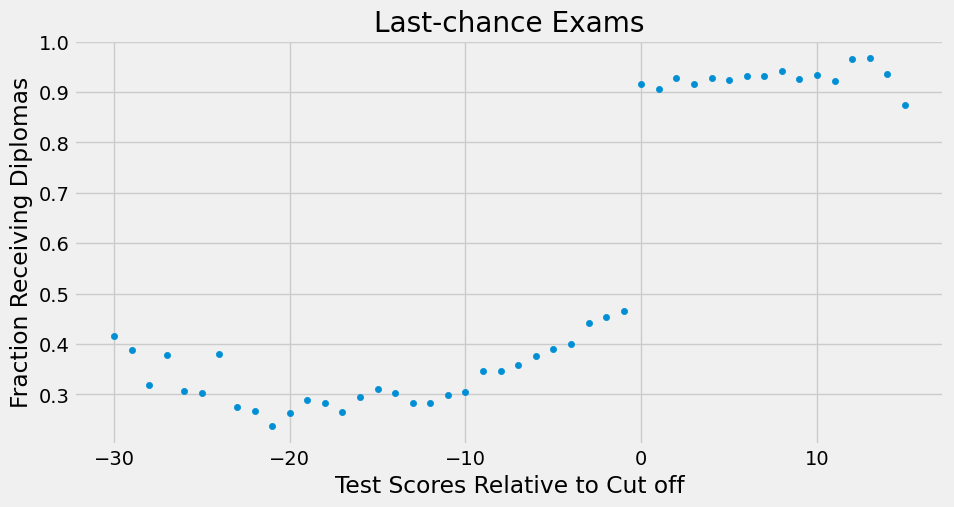

In [14]:
sheepskin.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams");

`fuzzy RD`는 일종의 `non compliance` 문제로 생각할 수 있습니다. 임계값을 넘은 모든 학생은 졸업장을 받지만, 몇몇 `never takers`는 절대로 받지 못합니다. 마찬가지로 임계값 이하에 해당하는 학생은 졸업장을 받지 못하지만 `always takers`는 어쨌든 받게 됩니다.

`potential outcome`과 마찬가지로 `potential treatment`를 생각할 수 있습니다. $T_1$은 모든 사람이 임계값 이상일 때 받았을 처치입니다. $T_0$은 모든 사람이 임계값 이하일 때 받았을 처치입니다. 아시다시피 **임계값은 도구 변수**로 생각할 수 있습니다. `IV`에서와 마찬가지로 단순하게 처치 효과를 추정한다면 효과는 0으로 편향됩니다.

![img](./data/img/rdd/rdd_fuzzy.png)

임계값 이상에서 처치 확률이 1보다 작으면 측정 결과는 `potential outcome` 참값인 $Y_1$보다 작아집니다. 같은 이유로 임계값 아래에서 관찰한 결과는 `potential outcome` 참값인 $Y_0$보다 커집니다. `non compliance`는 처치 효과를 실제보다 작게 만드므로 처치 효과를 제대로 추정하기 위해서는 `IV` 기법을 사용해야 합니다.

`RDD`에서 `potential outcome`의 연속성을 가정한 것과 같이 `potential treatment`도 연속으로 가정합니다. 또한, `IV`에서와 같이 단조성을 가정할 필요가 있습니다. $T_{i1}>T_{i0} \ \forall i$입니다. 이는 임계값을 왼쪽에서 오른쪽으로 넘을 때 졸업장을 받을 확률이 높아짐을 의미합니다. 두 가정을 통해 `Wald Estimator`로 `LATE`를 얻을 수 있습니다.

$$
\dfrac{\lim_{r \to c^+} E[Y_i|R_i=r] - \lim_{r \to c^-} E[Y_i|R_i=r]}{\lim_{r \to c^+} E[T_i|R_i=r] - \lim_{r \to c^-} E[T_i|R_i=r]} = E[Y_{1i} - Y_{0i} | T_{1i} > T_{0i}, R_i=c]
$$

추정치는 다음 두 가지 의미에서 국소적입니다. 첫째, 임계값 $c$에서의 처치 효과입니다 (`RD locality`). 둘째, `compliers` 만의 처치 효과입니다 (`IV locality`).

인과 추론을 위해 2개의 선형 회귀를 사용할 것입니다. 분자는 앞에서 했던 것과 같은 방법으로 추정합니다. 분모는 `outcome`을 `treatment`로 대체하여 얻습니다. 추정값을 구하기 전에 `RDD` 추정값을 신뢰도를 확인할 수 있는 검사 방법을 알아보겠습니다.

### The McCrary Test

`RDD` 결과가 부정되는 한가지 이유는 임계값 근방의 데이터 조작입니다. 양가죽 예제에서는 임계값 바로 아래에 있는 학생들이 시험 점수를 조금이라도 올릴 방법을 찾을 때 발생할 수 있습니다. 다른 예는 정부 혜택을 받기 위한 소득 수준입니다. 일부 사람들은 혜택을 받으려고 일부러 소득을 낮출 수 있습니다.

데이터가 조작되었을 때 `running variable`의 밀도에서 `bunching`이라고 불리는 현상이 발생하는 경향이 있습니다. 즉, 임계값 전후로 많은 데이터가 밀집됩니다. 시각적으로 확인하기 위해 `running variable`의 밀도 함수를 그려 임계값 주변에 튀는 점이 있는지 확인합니다. 예시에서는 밀도가 `n`으로 주어졌습니다.

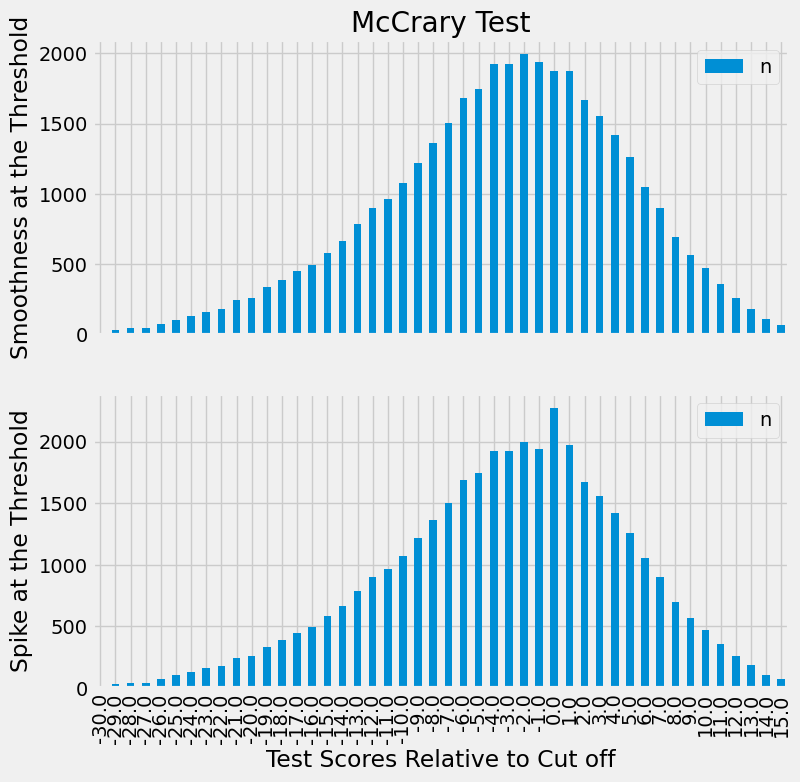

In [15]:
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheepskin.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheepskin.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold");

첫 번째 그림은 데이터 밀도를 그대로 보여줍니다. 임계값 근방에서 튀는 점이 없습니다. 즉, 데이터가 뭉쳐있지 않습니다. 임계값 근방 학생들의 점수는 조작되지 않은 것으로 보입니다. 두 번째 그림은 임계값 근방 학생들의 점수가 조작되었다면 어땠을지 보여줍니다. 임계값 바로 위에서 데이터 밀도가 급증하는 것을 볼 수 있습니다. 많은 학생이 조작으로 겨우 시험에 통과했기 때문입니다.

다시 양가죽 효과 추정으로 돌아갑시다. `Wald estimator`의 분자는 `Sharp RD`과 같은 방법으로 추정합니다. 여기서는 `bandwidth`가 15인 커널을 사용하겠습니다. 데이터 크기인 `n`을 알고 있으므로 커널에 샘플 크기를 곱해서 최종 가중치를 얻습니다.

In [16]:
sheepsking_rdd = sheepskin.assign(threshold=(sheepskin["minscore"]>0).astype(int))
model = smf.wls("avgearnings~minscore*threshold",
                sheepsking_rdd,
                weights=kernel(sheepsking_rdd["minscore"], c=0, h=15)*sheepsking_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


졸업장의 효과는 -97.7571이지만 통계적으로 유의하지 않습니다 (`p-value`=0.5). 회귀선을 그려보면 임계값 근방에서 연속적인 선으로 표기됩니다. 교육을 오래 받은 사람은 실제로 더 많은 돈을 벌지만, 졸업장으로 수입이 점프하지는 않습니다. 따라서 교육은 사람들을 생산적으로 만들어 소득을 올려줍니다. 즉, 양가죽 효과가 없습니다.

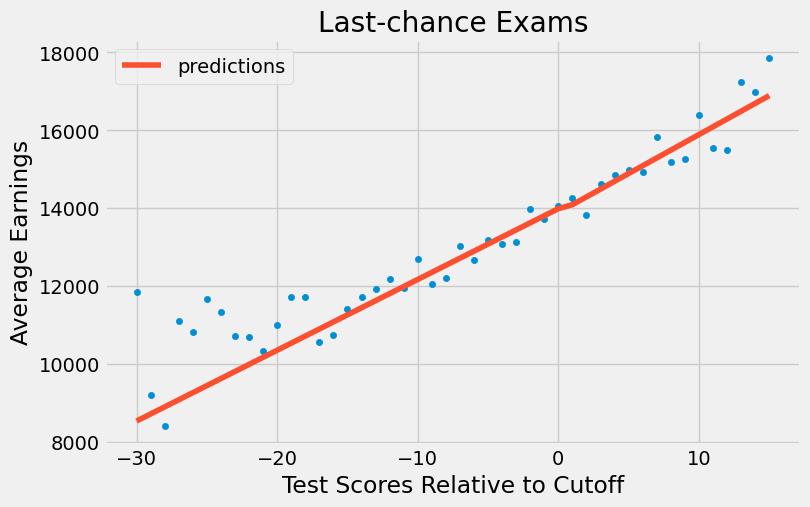

In [17]:
ax = sheepskin.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheepskin.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams");

하지만 `non compliance` 상황에서 인과 효과는 0으로 편향됩니다. 편향을 보정하기 위해서 인과 효과의 스케일을 조정해야 합니다. 안타깝게도 잘 만들어진 Python 구현체가 없으므로 표준 오차를 위해 수동으로 부트스트랩을 실행하겠습니다.

아래 코드는 `Wald estimator`의 분자를 추정하고, `target`을 `treatment`인 `receivehsd`로 대체해 분모를 얻습니다. 마지막 단계에서 분자를 분모로 나눕니다.

In [18]:
def wald_rdd(data):
    weights=kernel(data["minscore"], c=0, h=15)*data["n"]
    denominator = smf.wls("receivehsd~minscore*threshold", data, weights=weights).fit()
    numerator = smf.wls("avgearnings~minscore*threshold", data, weights=weights).fit()
    return numerator.params["threshold"]/denominator.params["threshold"]

In [19]:
from joblib import Parallel, delayed 

np.random.seed(45)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(wald_rdd)(sheepsking_rdd.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

부트스트랩 샘플로 `ATE` 분포를 그려 95% 신뢰 구간을 얻을 수 있습니다.

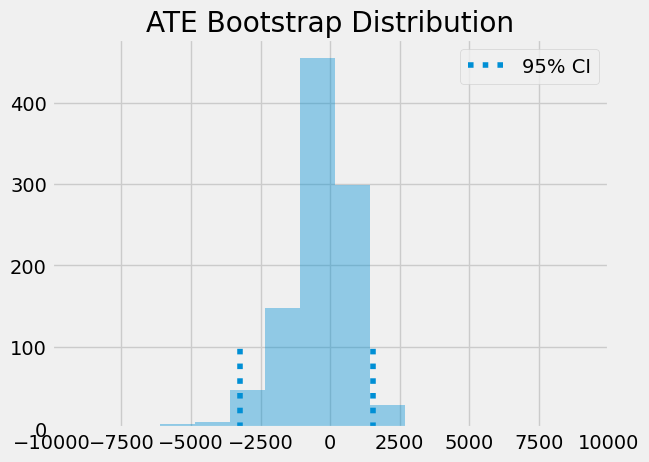

In [20]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 100, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 100, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.xlim([-10000, 10000])
plt.legend();

보시다시피 인과 효과를 스케일링해도 통계적으로 0과 다르지 않습니다. 즉, 양가죽 효과는 없습니다.

## Key Ideas

16장에서는 인과 효과를 추정하기 위해 인위적인 불연속성을 활용하는 방법(`RDD`)을 배웠습니다. `RDD`는 `treatment` 확률이 급격하게 높아지는 임계값을 활용합니다. `RDD` 예시로 음주가 사망률에 미치는 영향을 추정했습니다. `RDD`에서 임계값 근방의 데이터를 무작위 실험결과로 가정합니다. 임계값 근방의 데이터는 어느 방향으로도 갈 수 있으며 이를 결정하는 것은 순전히 무작위적이기 때문입니다. 따라서 임계값 전후를 비교해 처치 효과를 얻을 수 있었습니다. 또한, 커널을 사용하는 방법, `ATE`에 대한 표준 오차를 얻는 방법을 배웠습니다.

`non compliance` 상황과 비슷한 `fuzzy RD`도 살펴보았습니다. `IV`에서 했던 것과 마찬가지로 `first stage`를 `scale`하여 문제를 해결할 수 있었습니다.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Other important reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).